# Part 1: Choosing a labelled image classification dataset and description

Background:
I chose a labelled image classification dataset from a Kaggle competition. 
Kaggle is a crowd-sourced platform to attract, nurture, train and challenge data scientists from all around the world to solve data science, machine learning and predictive analytics problems. Kaggle gives data science enthusiasts a platform to interact and compete in solving real-life problems. The experience you get on Kaggle is invaluable in preparing you to understand what goes into finding feasible solutions for big data. [1]
Kaggle Competitions [2] are designed to provide challenges for competitors at all different stages of their machine learning careers. As a result, they are very diverse, with a range of broad types.

Size/Shape:
All the images in the dataset are of variable size and overall have more than 200 pixels in width and  200 pixels in height. Also, all the pictures have 3 colour channels (Red,Green and Blue).


Method of collection: 
I used a subset of the data for this part (The original data was too large). The complete data can be found at https://www.kaggle.com/c/dogs-vs-cats/data
I divided the data set (202 images) into training set(162 images) and validation set (40 images). Next, I trained the model and then tested on the validation set.<br>
The dataset created for this assignment can be found at https://github.com/sprabhu07/DeepLearning/tree/develop/dataset


Classes:
As needed,the dataset has only two classes: Dog & Cat (sample images from the dataset are as below)


                                          Cat
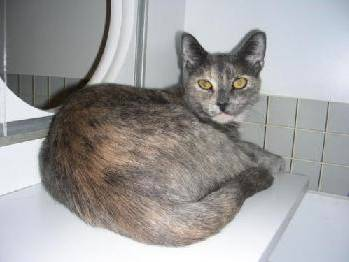

                                             Dog
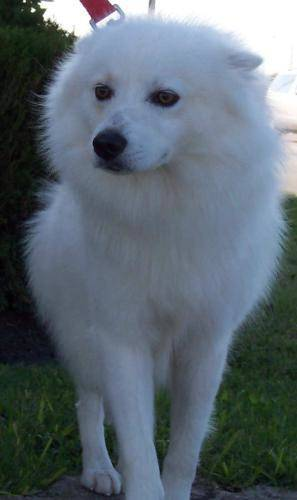

In [3]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
DS_all = tf.keras.preprocessing.image_dataset_from_directory('./dataset/',validation_split=0.2,subset='training',seed=42,batch_size=1000) # train split ,default image size is 256x256 
DS = tf.keras.preprocessing.image_dataset_from_directory('./dataset/',validation_split=0.2,subset='training',seed=42,batch_size=32)       # train split

val_DS = tf.keras.preprocessing.image_dataset_from_directory('./dataset/',validation_split=0.2,subset='validation',seed=42) # validation split

Found 202 files belonging to 2 classes.
Using 162 files for training.
Found 202 files belonging to 2 classes.
Using 162 files for training.
Found 202 files belonging to 2 classes.
Using 40 files for validation.


In [5]:
train_ds=DS       # set as training data set

Plotting the dataset with labels. Dogs are 1's and Cats are 0's

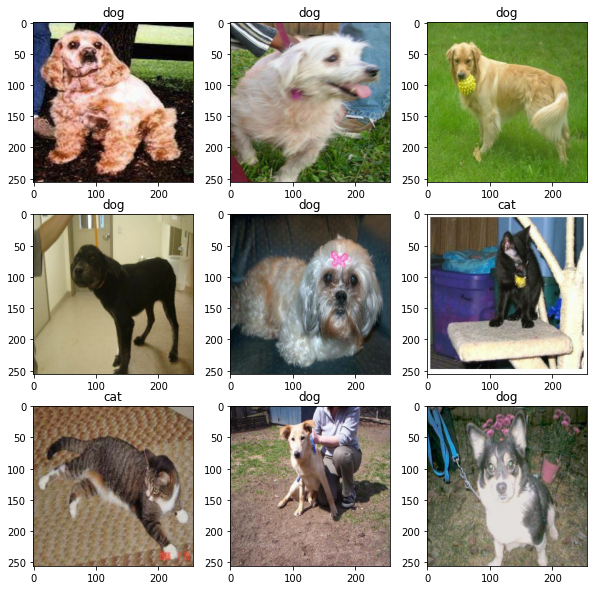

In [6]:
for p in train_ds.take(1):                                            # take some samples from the training set
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)                                 # plot with subplots
        plt.imshow(np.array(p[0][i]).astype(int))                     # show the image with pyplot
        plt.title(train_ds.class_names[int(p[1][i])])
#         plt.axis("off")

# Part 2: Pretrained image classification model

Choice of base model:
I chose VGG16 as the pretrained image classification model [3] and excluded the dense classification head. I set the input shape for the model as (256,256,3) which means the inputs/images are to be of size 256 x 256 with 3 colour channels (RGB). 

Preprocessing:
I used the image_dataset_from_directory[4] function for preprocessing from the Keras library. This utility function helps us in making data subsets (train,validation,test etc) and more importantly, makes sure that the images are in the necessary format. The image_size parameter of the said function is unused because the default image size is taken to be (256,256) which matches our requirement.

Layers and output:
The model has many layers mainly, conv2D and maxpooling2D layers. The final output without the dense classification head is a maxpooling2d layer which max pools the 16x16x512 input from the conv2d layer to a 8x8x512 output. 

Addition of layers:
First, we added three image augmentation layers with some randomness (horizontal flip,rotation,zoom). Next, we added a normalization layer for the inputs.After this, a GlobalAveragePooling2D layer was added followed by a Dropout layer to avoid overfitting.Finally, a single dense layer with one output was added as the final layer.

Training:
For compiling the model, Adam was chosen as the optimizer, BinaryCrossEntropy was selected as the loss function and BinaryAccuracy was picked as the metric.

1) First,the base model was frozen and it was then trained for 100 epochs with the training data. <br>
2) Then, we set the base model to be trainable (a bit of fine tuning) and then trained for 10 epochs. <br>
3) The classification accuracy for this model on the unseen data was 0.925000011920929 and the training accuracy was 0.9876543283462524.


In [4]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),         # random rotate by the given value
        layers.experimental.preprocessing.RandomZoom(0.1)              # random zoom by the given value
    ]
)


In [6]:
base_model = keras.applications.vgg16.VGG16(             # use VGG16
    weights="imagenet",                                  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),                           # set input shape as 256x256x3
    include_top=False                                    # exclude the dense classification head
) 
base_model.summary()                                    

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [13]:
base_model.trainable = False                                        # freeze the base model

inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)                                        # Apply random data augmentation

norm_layer = keras.layers.experimental.preprocessing.Normalization() # initilaise a Normalization layer
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)                                                    
norm_layer.set_weights([mean, var])                                  # set mean and variance to norm layer

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)                         # add a GlobalAveragePooling2D layer
x = keras.layers.Dropout(0.2)(x)                                     # Regularize with dropout layer
outputs = keras.layers.Dense(1)(x)                                   # add a dense layer
tmodel = keras.Model(inputs, outputs)                                # create the model

tmodel.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 256, 256, 3)       7         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513 

In [14]:
tmodel.compile(
    optimizer=keras.optimizers.Adam(),                             # optimizer is Adam
    loss=keras.losses.BinaryCrossentropy(from_logits=True),        # BinaryCrossEntropy is the loss function
    metrics=[keras.metrics.BinaryAccuracy()]                       # BinaryAccuracy us the metric for accuracy
)

# put to 20
epochs = 100
tmodel.fit(train_ds, epochs=epochs)

Epoch 1/100
6/6 [==============================] - 2s 131ms/step - loss: 0.7776 - binary_accuracy: 0.4789
Epoch 2/100
6/6 [==============================] - 1s 133ms/step - loss: 0.7326 - binary_accuracy: 0.4965
Epoch 3/100
6/6 [==============================] - 1s 131ms/step - loss: 0.7555 - binary_accuracy: 0.4984
Epoch 4/100
6/6 [==============================] - 1s 130ms/step - loss: 0.7057 - binary_accuracy: 0.5429
Epoch 5/100
6/6 [==============================] - 1s 131ms/step - loss: 0.7430 - binary_accuracy: 0.5157
Epoch 6/100
6/6 [==============================] - 1s 132ms/step - loss: 0.7080 - binary_accuracy: 0.5196
Epoch 7/100
6/6 [==============================] - 1s 131ms/step - loss: 0.7231 - binary_accuracy: 0.4990
Epoch 8/100
6/6 [==============================] - 1s 132ms/step - loss: 0.6989 - binary_accuracy: 0.4961
Epoch 9/100
6/6 [==============================] - 1s 131ms/step - loss: 0.7188 - binary_accuracy: 0.4750
Epoch 10/100
6/6 [============================

In [15]:
base_model.trainable = True                                      # unfreeze the model, fine tune it
tmodel.summary()

tmodel.compile(
    optimizer=keras.optimizers.Adam(1e-5),                       # Low learning rate,optimizer is Adam
    loss=keras.losses.BinaryCrossentropy(from_logits=True),      # BinaryCrossEntropy is the loss function
    metrics=[keras.metrics.BinaryAccuracy()]                     # BinaryAccuracy us the metric for accuracy                    
)

#put to 10
epochs = 10
tmodel.fit(DS, epochs=epochs)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
normalization_2 (Normalizati (None, 256, 256, 3)       7         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513 

In [16]:
tmodel.evaluate(train_ds)                 # check training accuracy

6/6 [==============================] - 2s 130ms/step - loss: 0.0411 - binary_accuracy: 0.9877


[0.04109949991106987, 0.9876543283462524]

In [17]:
tmodel.evaluate(val_DS)                  # check test accuracy

2/2 [==============================] - 10s 2s/step - loss: 0.1664 - binary_accuracy: 0.9250


[0.1664254367351532, 0.925000011920929]

In [19]:
tmodel.save("../dog-cat-model2")

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

# Part 3: Investigate the base model

In [20]:
inputs = keras.Input(shape=(256, 256, 3)) # reset base-model to try if it changed
 
x=base_model(inputs,training=False)      

new_model = keras.layers.GlobalMaxPooling2D()(x)                           # add a GlobalMaxPooling2D layer
new_model = keras.layers.Activation(keras.activations.softmax)(new_model)  # add a SoftMax layer
modelT = keras.Model(inputs, x)                                            # baseModel
modelChoiceT = keras.Model(inputs, new_model)                              # new Model with added layers

In [21]:
inputs = keras.Input(shape=(256, 256, 3))
# reset base-model to try if it changed
base_model = keras.applications.vgg16.VGG16(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
) 
x=base_model(inputs,training=False)

new_model = keras.layers.GlobalMaxPooling2D()(x)
new_model = keras.layers.Activation(keras.activations.softmax)(new_model)
model = keras.Model(inputs, x)
modelChoice = keras.Model(inputs, new_model)

In [22]:
modelChoice.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


### Correlation Graph with finetuning

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


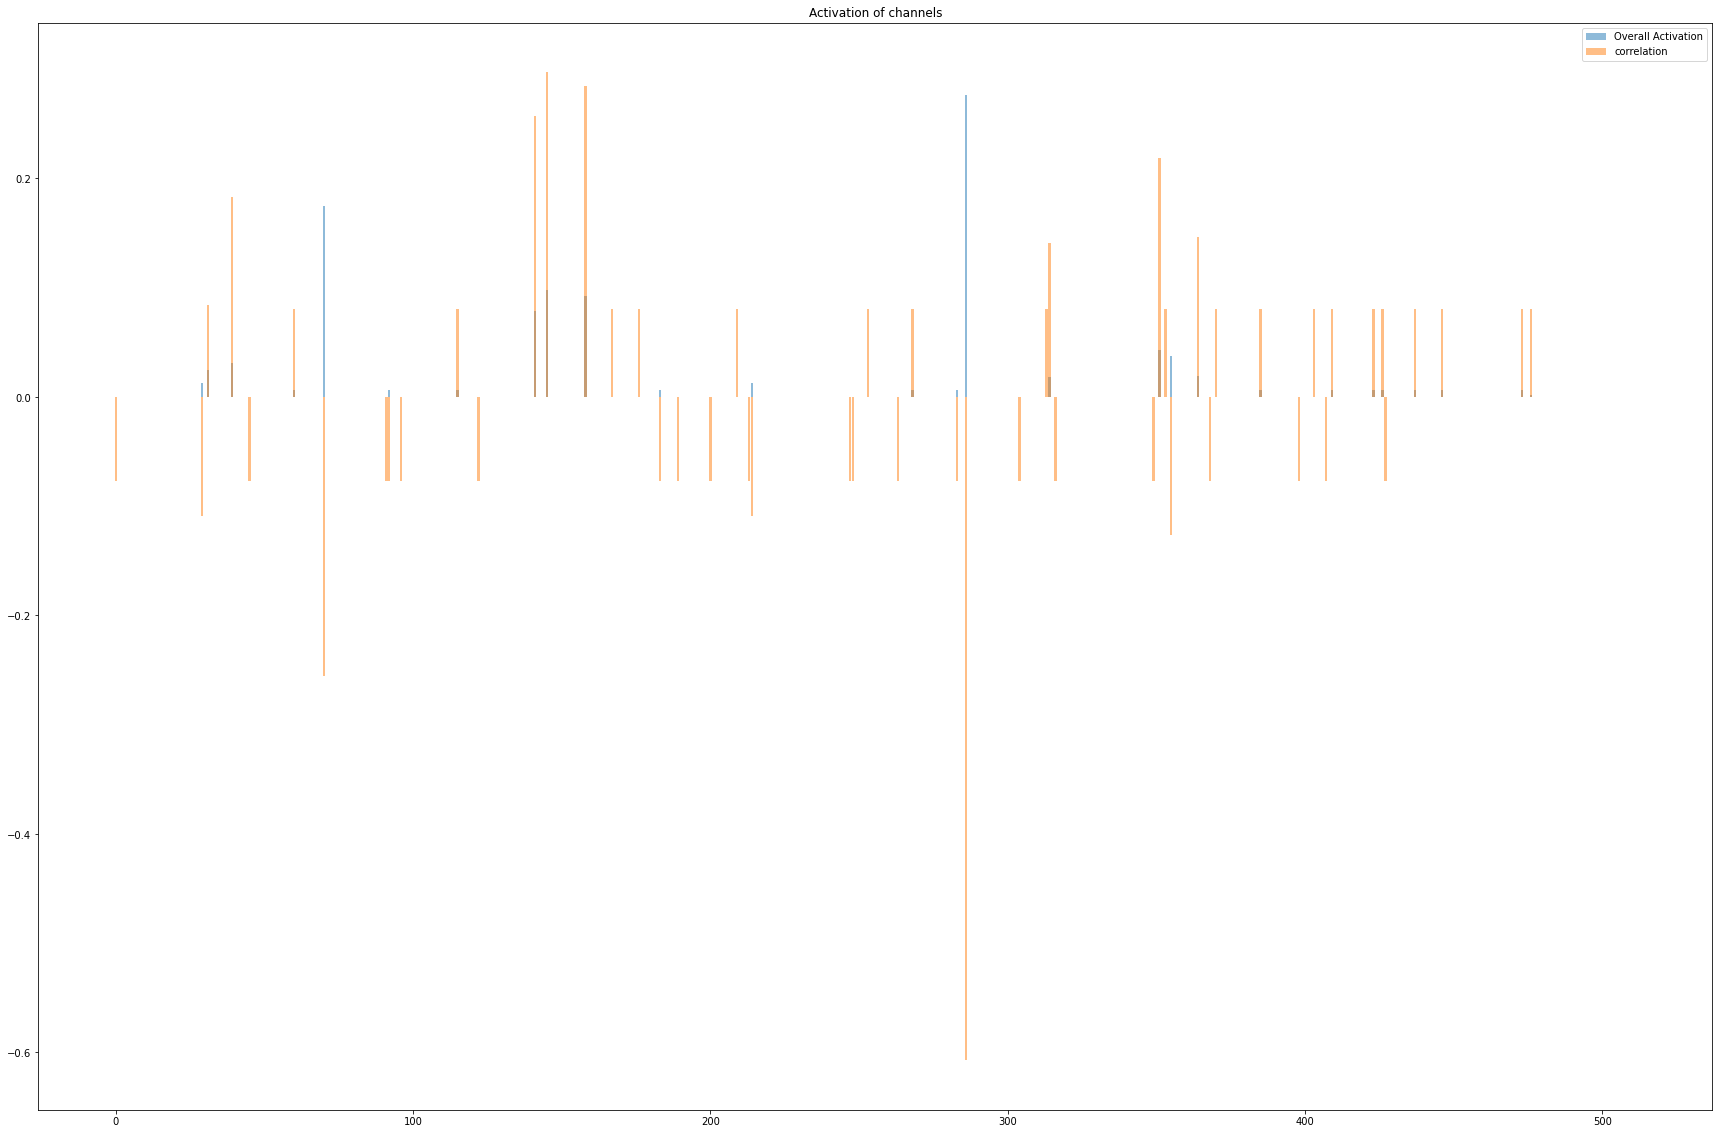

In [25]:
# res = modelChoice.predict(DS_all) # predict on all data
# get data with Y values
d= list(DS_all.take(1).as_numpy_iterator()) 
dt = d[0][0] # gets the data (images)
yt = d[0][1] # gets the true values 

#predict on data
rest = modelChoiceT.predict(dt)

rest.shape,dt.shape,yt.shape

corr = []
for v in range(512):
#     print(v,np.corrcoef(yt,rest[:,v])[0,1])
    corr.append(np.corrcoef(yt,rest[:,v])[0,1])
# corr = [c if c != np.NAN else 0 for c in corr ]
corr=np.nan_to_num(np.array(corr))

rest.shape

import numpy as np

senset = np.sum(rest,axis=0) # Sum over samples
senset = senset/np.sum(senset) # devide to normalize and reach same range as layer output

plt.figure(figsize=(30,20))
plt.bar(list(range(len(senset))),senset, label ="Overall Activation",alpha=0.5)
plt.bar(list(range(512)),corr,label="correlation",alpha=0.5)
plt.title("Activation of channels")
plt.legend()

### Correlaton Graph without finetuning

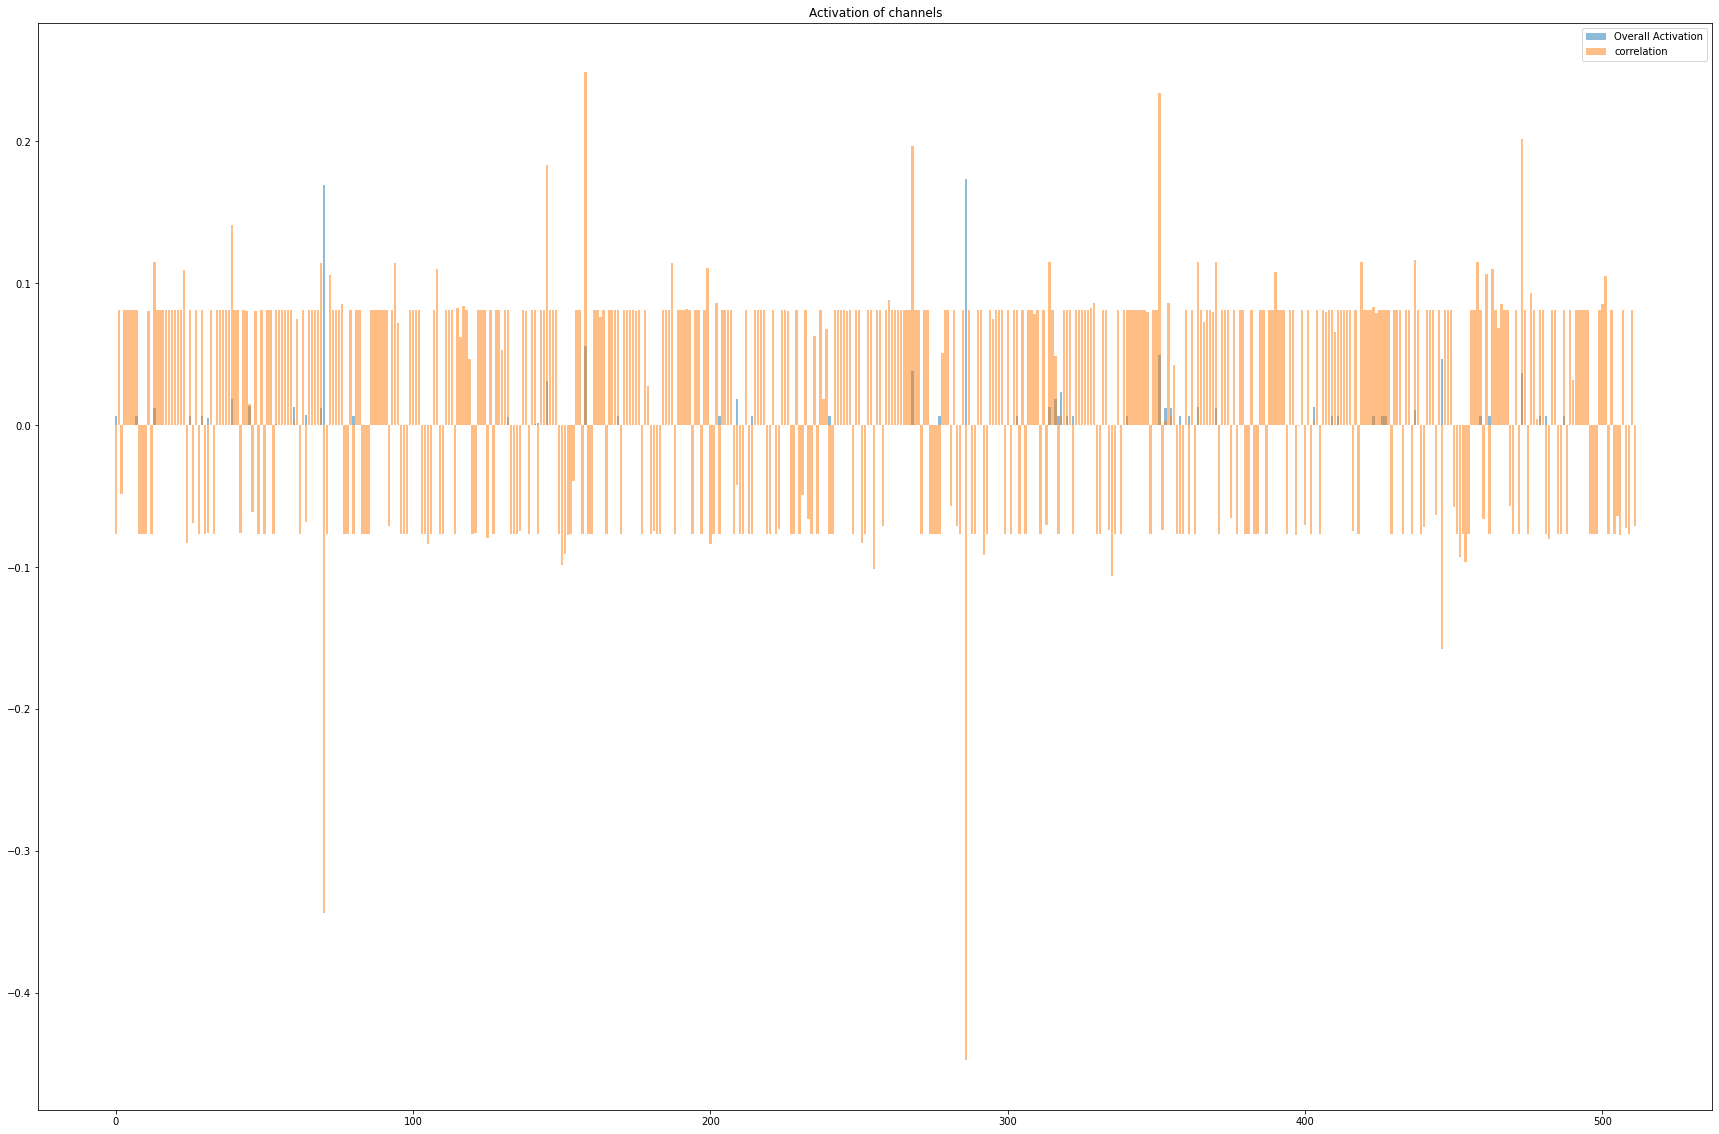

In [27]:
# res = modelChoice.predict(DS_all) # predict on all data
# get data with Y values
d= list(DS_all.take(1).as_numpy_iterator()) 
dt = d[0][0] # gets the data (images)
yt = d[0][1] # gets the true values 

#predict on data
rest = modelChoice.predict(dt)

rest.shape,dt.shape,yt.shape

corr = []
for v in range(512):
#     print(v,np.corrcoef(yt,rest[:,v])[0,1])
    corr.append(np.corrcoef(yt,rest[:,v])[0,1])
# corr = [c if c != np.NAN else 0 for c in corr ]
corr=np.nan_to_num(np.array(corr))

rest.shape

import numpy as np

senset = np.sum(rest,axis=0) # Sum over samples
senset = senset/np.sum(senset) # devide to normalize and reach same range as layer output

plt.figure(figsize=(30,20))
plt.bar(list(range(len(senset))),senset, label ="Overall Activation",alpha=0.5)
plt.bar(list(range(512)),corr,label="correlation",alpha=0.5)
plt.title("Activation of channels")
plt.legend()

As can be seen, the finetuning made the graph correlation sparser, presumably by tuning to only rely on important features.

Furthermore, it can be seen that there are definetly some spikes in the activations which would be interesting to investigate. A lot if the activation sum and correlation spikes appear to line up. Therefore it would be resonable ot say there are neurons that are specifically activated by the cats and dogs in the images.

# Part 4: Object Localisation and Visualisation

In [28]:
interestC = np.abs(corr).argsort()[-10:] # most correlated neurons
interestA = senset.argsort()[-10:] # interest based on activation only

Intersting neurons for **A**ctivation based selection and **C**orrelation based

In [29]:
interestA,interestC

(array([316, 318, 145, 473, 268, 446, 351, 158,  70, 286]),
 array([437,  39, 446, 145, 268, 473, 351, 158,  70, 286]))

Below the Correlations sorted by magnitude.

In [30]:
for i in reversed(interestC):
    print("Correlation Neuron:","%03d"%i,'\tValue:',str(round(corr[i],3)).ljust(6,' '))

Correlation Neuron: 286 	Value: -0.448
Correlation Neuron: 070 	Value: -0.344
Correlation Neuron: 158 	Value: 0.249 
Correlation Neuron: 351 	Value: 0.234 
Correlation Neuron: 473 	Value: 0.201 
Correlation Neuron: 268 	Value: 0.196 
Correlation Neuron: 145 	Value: 0.183 
Correlation Neuron: 446 	Value: -0.158
Correlation Neuron: 039 	Value: 0.141 
Correlation Neuron: 437 	Value: 0.117 


 As Dogs are 1's and Cats are 0's, one can say that all negative correlation neurons e.g. 286 and 70 are predictors for Cats and positive ones for Dogs e.g. 158 and 351. However there is no reason to assume that activation is the 'predictor' so it coud very well be, that a lack of it may indicate presence of something. However, they definetly seem to be responding in a way to the object displayed.


# Plot neurons activation
In this section the acitivty from the chosen neurongs above are plotted

In [31]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import cv2

In order to show nicely how the activations and images correlate, the activations are plotted abovethe images themselves. The method below generatesthe images from the training set and plot them above the image as well as the activatio sum next to it. On demand, the individual outputs can also be plotted.

In [32]:
images = list(train_ds.take(1).as_numpy_iterator()) # get images form dataset
def plotInterest(interest,imagenum,plot_neurons = False):
    cmap=cm.get_cmap('viridis')   # use color map
    normalizer=Normalize(0,300)   #Normalizer, 300 seems to be the max activation given
    acts = np.zeros((8,8))   # area sum
    im=cm.ScalarMappable(norm=normalizer)
#     print(images[0][1])
    t = np.expand_dims(images[0][0][imagenum].astype(int), axis=0)
    res = model.predict(t)
    if plot_neurons:
        # generate grid for per-neuron activation
        fig, axes = plt.subplots(nrows=2, ncols=5)
    for i in range(len(interest)):
        img=res[0,:,:,interest[i]]
        acts = acts+img
        if plot_neurons:
            #plot neuron activation
            axes.flat[i].imshow(img,cmap=cmap,norm=normalizer)
            axes.flat[i].set_title("N %d"%interest[i])
    #     plt.colorbar()
    if plot_neurons:
        fig.subplots_adjust(right=0.8)
        #adjust bar
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        plt.show()
    fig, axes = plt.subplots(nrows=1, ncols=2)
    cmap=cm.get_cmap('viridis')
    normalizer=Normalize(0,300)
    a=axes[0]
    a.imshow(t[0],alpha=1)
    a.imshow(cv2.resize(acts,dsize=(256,256)),alpha=0.5)
    axes[1].imshow(acts,alpha=0.5)
    plt.show()
    # a.imshow([1,2,30],[2,3,40])
    # a.imshow(img,cmap=cmap,norm=normalizer,alpha=0.25)

## Plotting of Activation based on Correlation

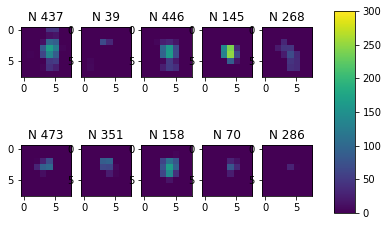

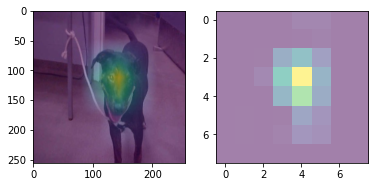

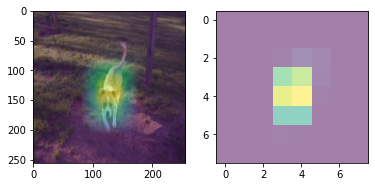

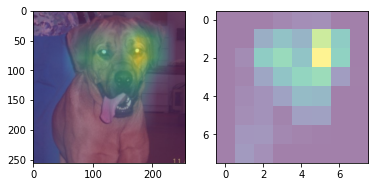

In [33]:
plotInterest(interestC,1,plot_neurons=True)
plotInterest(interestC,2)
plotInterest(interestC,3)

As can be seen, the nodes appear to locate the faces of the cats. The nodes overall appear to be good locators of the object.

## Plotting of Activation based on Activation overall

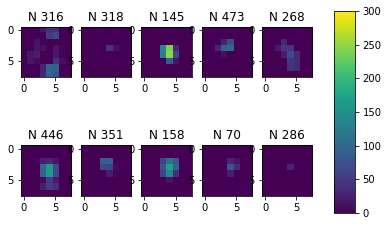

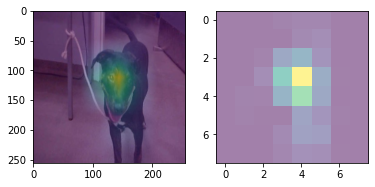

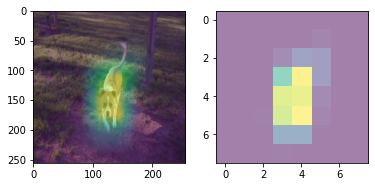

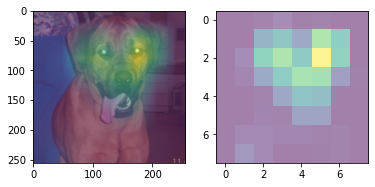

In [34]:
plotInterest(interestA,1,plot_neurons=True)
plotInterest(interestA,2)
plotInterest(interestA,3)

The activation also creates a clear highlight of the face, which is also likely given that a lot of neurons are shared. It appears though, that the correltation based neurons are a bit more consize and the noise appears to be better distributed around the object of interest. Overal both choices appear be valid for locating objects in the image.

# Conclusion

Overall it can be said, that the neurons activation seems to consistently locate the head and/or the legs of the cat/dog. Although it is difficult to say how well this will work on images where the objects are smaller, it appears to be a good locator of the objects that are being classified.

# References

1)	https://www.kaggle.com <br>
2)	https://www.kaggle.com/docs/competitions  <br>
3)	https://keras.io/api/applications/vgg/#vgg16-function <br>
4)	https://keras.io/api/preprocessing/image/  